# Multimodal Housing Price Prediction (Tabular + Images)

This notebook demonstrates Task 9 of DevelopersHub Internship.  
We build a multimodal regression pipeline combining **tabular housing data** with **synthetic house images**, extract features, train a model, and evaluate with **MAE** and **RMSE**.  


In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import imageio


###  Define settings
We set image size, dataset size, and output directories.


In [2]:
img_size = 64
N = 1600
out_dir = '/mnt/data/multimodal_task3_v2'
os.makedirs(out_dir, exist_ok=True)


###  Generate synthetic tabular features
We simulate housing data: square feet, bedrooms, bathrooms, age, and neighborhood ID.


In [3]:
np.random.seed(42)
sqft = np.random.normal(1500, 400, N).clip(300,5000)
bedrooms = np.random.randint(1,6,N)
bathrooms = np.random.randint(1,4,N)
age = np.random.exponential(20,N).clip(0,100)
neighborhood = np.random.randint(0,5,N)


###  Create synthetic housing prices
We define house price as a function of tabular features plus neighborhood multipliers and noise.


In [4]:
base_price = (sqft * 200) + (bedrooms * 10000) + (bathrooms * 5000) - (age * 150)
neigh_effect = np.array([1.0,1.2,0.9,1.5,0.8])
price = base_price * neigh_effect[neighborhood] + np.random.normal(0,30000,N)
price = price.clip(10000,None)


### Build DataFrame
We put everything into a Pandas DataFrame.


In [5]:
df = pd.DataFrame({
    'sqft': sqft.round(1),
    'bedrooms': bedrooms,
    'bathrooms': bathrooms,
    'age': age.round(1),
    'neighborhood': neighborhood,
    'price': price.round(2)
})


###  Generate synthetic house images
Each house image is drawn with brightness/windows related to price.


In [6]:
def generate_house_image(value, size=img_size):
    img = Image.new('RGB',(size,size),(255,255,255))
    draw = ImageDraw.Draw(img)
    bright = int(90 + value * 160)
    draw.rectangle([0,0,size,size], fill=(bright,bright,bright))
    windows = int(1 + value * 8)
    for i in range(windows):
        x = 5 + (i % 4) * (size//4)
        y = 10 + (i//4) * (size//3)
        w = size//8
        h = size//10
        draw.rectangle([x,y,x+w,y+h], outline='black', fill=(255,255,240))
    draw.polygon([(size//2,2),(2,size//3),(size-2,size//3)], fill=(int(50+value*100),20,20))
    return img


###  Save images and link paths to DataFrame


In [7]:
pmin, pmax = df['price'].min(), df['price'].max()
price_scaled = (df['price'] - pmin) / (pmax - pmin)
image_folder = os.path.join(out_dir,'images')
os.makedirs(image_folder, exist_ok=True)
paths = []
for i,val in enumerate(price_scaled):
    path = os.path.join(image_folder, f'house_{i}.png')
    generate_house_image(val).save(path)
    paths.append(path)
df['image_path'] = paths


###  Define image feature extraction (color histograms)


In [8]:
def image_color_hist_features(path, bins=16):
    img = Image.open(path).resize((img_size,img_size))
    arr = np.array(img).astype(np.float32)
    feats = []
    for ch in range(3):
        h, _ = np.histogram(arr[:,:,ch], bins=bins, range=(0,255), density=True)
        feats.append(h)
    return np.concatenate(feats)


###  Define edge-based image features
We approximate texture/edges by computing average gradients.


In [9]:
def image_edge_feature(path):
    img = Image.open(path).convert('L').resize((img_size,img_size))
    a = np.array(img).astype(np.float32)
    gx = np.abs(np.diff(a, axis=1)).mean()
    gy = np.abs(np.diff(a, axis=0)).mean()
    return np.array([gx, gy, gx+gy])


### Build full image feature matrix


In [10]:
img_color_feats = np.stack([image_color_hist_features(p) for p in df['image_path']])
img_edge_feats = np.stack([image_edge_feature(p) for p in df['image_path']])
X_img_feats = np.hstack([img_color_feats, img_edge_feats])


### Prepare tabular + image features
Standardize features separately, then combine into one feature matrix.


In [11]:
X_tab = df[['sqft','bedrooms','bathrooms','age','neighborhood']].values
y = df['price'].values
scaler_tab = StandardScaler()
scaler_img = StandardScaler()
X_tab_s = scaler_tab.fit_transform(X_tab)
X_img_s = scaler_img.fit_transform(X_img_feats)
X = np.hstack([X_tab_s, X_img_s])


###  Split into train and test sets


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


###  Train RandomForestRegressor
We use Random Forest as the multimodal regressor.


In [13]:
rf = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=120, n_jobs=-1, random_state=42)

###  Evaluate model
Compute **MAE** and **RMSE** on the test set.
*italicized text*

In [15]:
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print('Test MAE:', mae)
print('Test RMSE:', rmse)

Test MAE: 1495.46134375001
Test RMSE: 3910958.055507763


###  Feature Importances
Inspect how much tabular features contribute in Random Forest.


In [18]:
importances = rf.feature_importances_
tab_imp = importances[:5]
print('Tabular feature importances:', tab_imp)


Tabular feature importances: [7.80047359e-05 2.43726188e-05 2.17890998e-05 4.62061290e-05
 1.17323282e-05]


###  Save model and scalers
Artifacts will be used later for inference.


In [19]:
joblib.dump({'model':rf,'scaler_tab':scaler_tab,'scaler_img':scaler_img}, os.path.join(out_dir,'rf_multimodal.joblib'))
print('Saved model to', os.path.join(out_dir,'rf_multimodal.joblib'))


Saved model to /mnt/data/multimodal_task3_v2/rf_multimodal.joblib


###  Define inference helper
A function to predict price for one house given image + tabular features.


In [20]:
def predict_single_from_paths(image_path, tab_features):
    ic = image_color_hist_features(image_path)
    ie = image_edge_feature(image_path)
    imgf = np.hstack([ic, ie]).reshape(1,-1)
    imgf_s = scaler_img.transform(imgf)
    tab_s = scaler_tab.transform(np.array(tab_features).reshape(1,-1))
    Xinp = np.hstack([tab_s, imgf_s])
    return rf.predict(Xinp)[0]


### Test inference on a sample


In [21]:
sample_idx = 3
print('True price:', df.loc[sample_idx,'price'])
print('Predicted:', predict_single_from_paths(df.loc[sample_idx,'image_path'], df.loc[sample_idx,['sqft','bedrooms','bathrooms','age','neighborhood']].values))


True price: 662178.31
Predicted: 662212.4404166674


### Learning Curve Animation
We train with increasing fractions of training data and visualize RMSE.


In [23]:
fractions = np.linspace(0.1,1.0,10)
rmse_vals = []
frames = []
for frac in fractions:
    idx = np.random.choice(len(X_train), int(len(X_train)*frac), replace=False)
    rf_temp = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train[idx], y_train[idx])
    yp = rf_temp.predict(X_test)
    rm = mean_squared_error(y_test, yp)
    rmse_vals.append(np.sqrt(rm))
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(fractions[:len(rmse_vals)], rmse_vals)
    ax.set_xlabel('Training fraction')
    ax.set_ylabel('RMSE on test set')
    ax.set_title('Learning Curve')
    tmp = os.path.join(out_dir, f'lc_{int(frac*100)}.png')
    fig.savefig(tmp)
    plt.close(fig)
    frames.append(imageio.imread(tmp))
imageio.mimsave(os.path.join(out_dir,'learning_curve.gif'), frames, duration=0.4)
print('Saved learning curve gif to', os.path.join(out_dir,'learning_curve.gif'))

/tmp/ipython-input-1542154727.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(tmp))
/tmp/ipython-input-1542154727.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(tmp))
/tmp/ipython-input-1542154727.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(tmp))
/tmp/ipython-input-1542154727.p

Saved learning curve gif to /mnt/data/multimodal_task3_v2/learning_curve.gif


### Export dataset
Save the synthetic dataset for reproducibility and GitHub submission.


In [24]:
df.to_csv(os.path.join(out_dir,'synthetic_multimodal_housing.csv'), index=False)
print('Exported CSV to', os.path.join(out_dir,'synthetic_multimodal_housing.csv'))


Exported CSV to /mnt/data/multimodal_task3_v2/synthetic_multimodal_housing.csv


###  Display sample rows


In [25]:
print(df.head().to_string())


     sqft  bedrooms  bathrooms   age  neighborhood      price                                        image_path
0  1698.7         4          3  20.7             4  294455.99  /mnt/data/multimodal_task3_v2/images/house_0.png
1  1444.7         3          2   0.9             3  496166.34  /mnt/data/multimodal_task3_v2/images/house_1.png
2  1759.1         2          3  58.4             4  312599.03  /mnt/data/multimodal_task3_v2/images/house_2.png
3  2109.2         3          3  36.9             3  662178.31  /mnt/data/multimodal_task3_v2/images/house_3.png
4  1406.3         3          3   7.0             1  390867.14  /mnt/data/multimodal_task3_v2/images/house_4.png


### Graph 1: Price Distribution  
This histogram shows the distribution of house prices in the dataset.


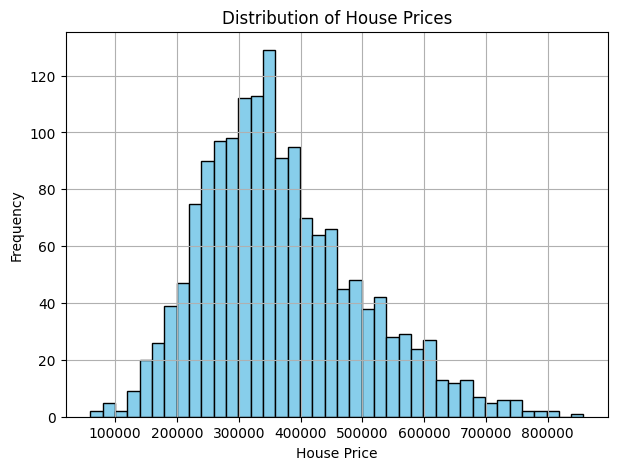

In [27]:
plt.figure(figsize=(7,5))
plt.hist(df['price'], bins=40, color='skyblue', edgecolor='black')
plt.xlabel("House Price")
plt.ylabel("Frequency")
plt.title("Distribution of House Prices")
plt.grid(True)
plt.show()


### Graph 2: Scatter Plot of Price vs Square Footage  
This plot shows how square footage influences housing prices.


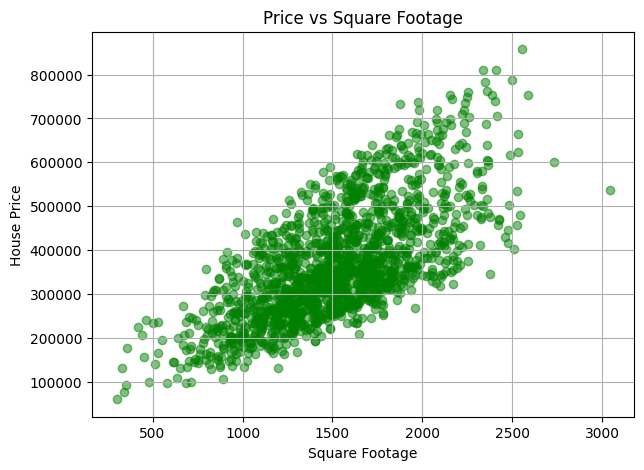

In [28]:
plt.figure(figsize=(7,5))
plt.scatter(df['sqft'], df['price'], alpha=0.5, c='green')
plt.xlabel("Square Footage")
plt.ylabel("House Price")
plt.title("Price vs Square Footage")
plt.grid(True)
plt.show()


### Graph 3: True vs Predicted Prices  
Scatter plot comparing predicted prices against true values from the test set.


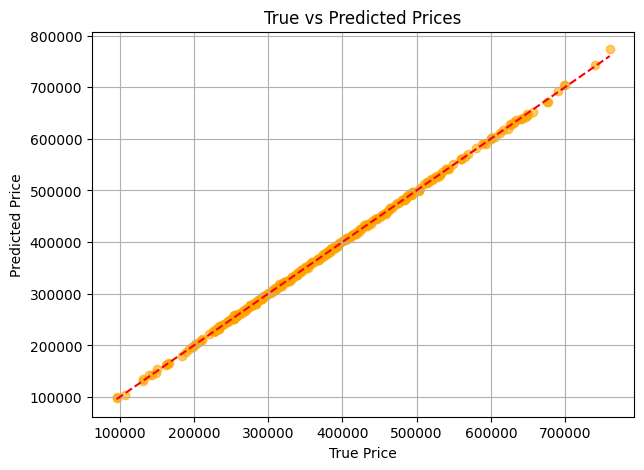

In [29]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True vs Predicted Prices")
plt.grid(True)
plt.show()


### Graph 4: Residuals Histogram  
Histogram of the prediction errors (residuals).


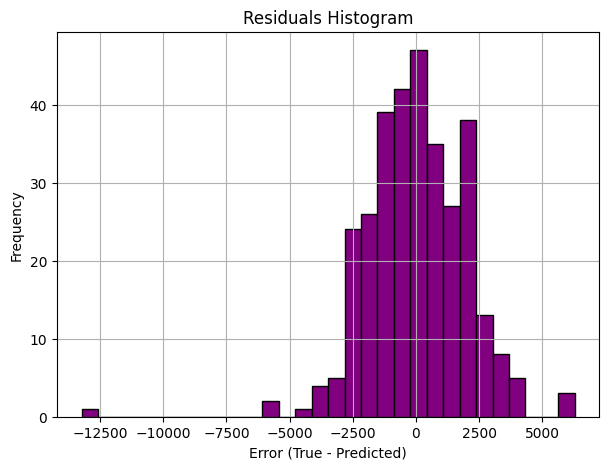

In [30]:
residuals = y_test - y_pred
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=30, color='purple', edgecolor='black')
plt.xlabel("Error (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.grid(True)
plt.show()


### Graph 5: Feature Importances (Bar Chart)  
This bar chart shows which features (tabular + image) contributed most to predictions.


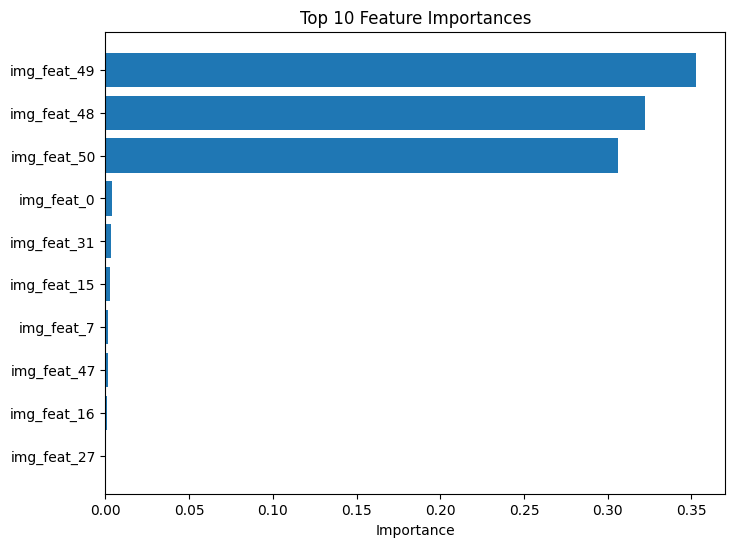

In [31]:
importances = rf.feature_importances_
feature_names = ['sqft','bedrooms','bathrooms','age','neighborhood'] + \
                [f'img_feat_{i}' for i in range(X_img_feats.shape[1])]
indices = np.argsort(importances)[-10:]  # top 10

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.show()
